In [22]:
# REEMPLAZAR primera celda: Imports para modelo v11 (TF-IDF + spaCy embeddings)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import pickle
import os
import subprocess
import sys
warnings.filterwarnings('ignore')

# Machine Learning básico
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb
from scipy.sparse import hstack, csr_matrix

print("🚀 INICIANDO MODELO V11 CON NLP CLÁSICO + spaCy")
print("=" * 50)

# Instalar spaCy y modelos pequeños si es necesario
def install_spacy_and_models():
    try:
        import spacy
        print("✅ spaCy ya instalado")
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy", "--quiet"])
        print("✅ spaCy instalado")
    # Descargar modelos pequeños
    import spacy
    try:
        spacy.load("es_core_news_sm")
        print("✅ es_core_news_sm ya descargado")
    except:
        spacy.cli.download("es_core_news_sm")
        print("✅ es_core_news_sm descargado")
    try:
        spacy.load("en_core_web_sm")
        print("✅ en_core_web_sm ya descargado")
    except:
        spacy.cli.download("en_core_web_sm")
        print("✅ en_core_web_sm descargado")

print("📦 Instalando/verificando spaCy y modelos...")
install_spacy_and_models()

# Imports NLP clásicos y spaCy
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

print("✅ Entorno modelo v11 preparado (TF-IDF + spaCy embeddings)")

🚀 INICIANDO MODELO V11 CON NLP CLÁSICO + spaCy
📦 Instalando/verificando spaCy y modelos...
✅ spaCy ya instalado
✅ es_core_news_sm ya descargado
✅ en_core_web_sm ya descargado
✅ Entorno modelo v11 preparado (TF-IDF + spaCy embeddings)


In [23]:
# CELDA NUEVA: Configurar NLTK
import ssl

print("📥 CONFIGURANDO NLTK PARA MODELO V11...")

# Configurar SSL para descargas
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Descargar recursos NLTK esenciales
nltk_resources = [
    'punkt',
    'stopwords', 
    'wordnet',
    'averaged_perceptron_tagger',
    'omw-1.4'
]

for resource in nltk_resources:
    try:
        nltk.download(resource, quiet=True)
        print(f"✅ {resource}")
    except Exception as e:
        print(f"⚠️ {resource}: {e}")

print("✅ NLTK configurado para modelo v11")

📥 CONFIGURANDO NLTK PARA MODELO V11...
⚠️ punkt: name 'nltk' is not defined
⚠️ stopwords: name 'nltk' is not defined
⚠️ wordnet: name 'nltk' is not defined
⚠️ averaged_perceptron_tagger: name 'nltk' is not defined
⚠️ omw-1.4: name 'nltk' is not defined
✅ NLTK configurado para modelo v11


In [24]:
#segunda celda: Cargar datasets para modelo v11
print("📦 CARGANDO DATASETS PARA MODELO V11 AVANZADO")
print("=" * 60)

# Cargar processed_medical_data.csv
try:
    df1 = pd.read_csv("datos/processed_medical_data.csv")
    print(f"✅ processed_medical_data.csv: {len(df1)} filas")
    print(f"   Columnas: {df1.columns.tolist()}")
except Exception as e:
    print(f"❌ Error: {e}")
    df1 = pd.DataFrame()

# Cargar Independent_Medical_Reviews.csv
try:
    df2 = pd.read_csv("datos/Independent_Medical_Reviews.csv")
    print(f"✅ Independent_Medical_Reviews.csv: {len(df2)} filas")
    print(f"   Columnas: {df2.columns.tolist()}")
except Exception as e:
    print(f"❌ Error: {e}")
    df2 = pd.DataFrame()

if not df1.empty:
    print(f"\n👀 Muestra dataset 1:")
    print(df1.head(2))

if not df2.empty:
    print(f"\n👀 Muestra dataset 2:")
    print(df2.head(2))

print("\n🎯 Objetivo: Modelo v11 con comprensión semántica avanzada")

📦 CARGANDO DATASETS PARA MODELO V11 AVANZADO
✅ processed_medical_data.csv: 446 filas
   Columnas: ['symptoms', 'diagnosis', 'original_diagnosis', 'admission_type', 'category']
✅ Independent_Medical_Reviews.csv: 19245 filas
   Columnas: ['Reference ID', 'Report Year', 'Diagnosis Category', 'Diagnosis Sub Category', 'Treatment Category', 'Treatment Sub Category', 'Determination', 'Type', 'Age Range', 'Patient Gender', 'Findings']

👀 Muestra dataset 1:
                                            symptoms         diagnosis  \
0  sleep with acute shortness of breath and cough...    Cardiovascular   
1  l movement he denies fevers chills nausea if y...  Gastrointestinal   

                              original_diagnosis admission_type  \
0   RESPIRATORY FAILURE;CONGESTIVE HEART FAILURE      EMERGENCY   
1                                 ABDOMINAL PAIN      EMERGENCY   

            category  
0  Discharge summary  
1  Discharge summary  

👀 Muestra dataset 2:
  Reference ID  Report Year Di

In [25]:
# CELDA NUEVA: Preprocesador médico avanzado con NLTK + spaCy embeddings
from typing import Dict, List, Optional
import re

class PreprocesadorMedicoV11:
    def __init__(self):
        """Preprocesador médico avanzado para modelo v11 (TF-IDF + spaCy embeddings)"""
        print("🧠 Inicializando preprocesador médico avanzado (spaCy)...")
        
        # Componentes NLTK
        try:
            self.lemmatizer = WordNetLemmatizer()
            self.stop_words_en = set(stopwords.words('english'))
            self.stop_words_es = set(stopwords.words('spanish'))
            print("✅ NLTK inicializado")
        except:
            self.lemmatizer = None
            self.stop_words_en = {'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'a', 'an', 'is', 'are', 'was', 'were'}
            self.stop_words_es = {'el', 'la', 'los', 'las', 'y', 'o', 'pero', 'en', 'de', 'con', 'por', 'para', 'un', 'una', 'es', 'son'}
            print("⚠️ NLTK fallback activado")
        
        # Cargar modelos spaCy solo una vez
        try:
            self.nlp_es = spacy.load("es_core_news_sm")
            self.nlp_en = spacy.load("en_core_web_sm")
            self.embedding_dim = self.nlp_es("hola").vector.shape[0]
            print(f"✅ spaCy cargado (dimensión embeddings: {self.embedding_dim})")
        except Exception as e:
            print(f"❌ Error cargando spaCy: {e}")
            self.nlp_es = None
            self.nlp_en = None
            self.embedding_dim = 0
        
        # Diccionario médico exhaustivo español-inglés
        self.medical_translations = {
            # ... (tu diccionario completo aquí, igual que antes) ...
            'yo tengo': 'patient presents with patient has',
            'me duele': 'patient experiences pain in pain located in',
            # ... (resto del diccionario igual) ...
            'gradualmente': 'gradually progressive slowly',
        }
        print(f"✅ Diccionario médico: {len(self.medical_translations)} términos")
    
    def detectar_idioma(self, texto: str) -> str:
        palabras_es = ['dolor', 'tengo', 'siento', 'mucho', 'cabeza', 'pecho', 'estómago', 'me', 'yo', 'muy', 'desde', 'hace']
        palabras_en = ['pain', 'have', 'feel', 'chest', 'head', 'stomach', 'back', 'breath', 'my', 'i', 'very', 'for', 'since']
        texto_lower = texto.lower()
        count_es = sum(1 for palabra in palabras_es if palabra in texto_lower)
        count_en = sum(1 for palabra in palabras_en if palabra in texto_lower)
        return 'spanish' if count_es > count_en else 'english'
    
    def aplicar_diccionario_medico(self, texto: str) -> str:
        texto_procesado = texto.lower().strip()
        for termino_es, termino_en in self.medical_translations.items():
            if termino_es in texto_procesado:
                texto_procesado = texto_procesado.replace(termino_es, f" {termino_en} ")
        texto_procesado = re.sub(r'\s+', ' ', texto_procesado).strip()
        return texto_procesado
    
    def limpiar_con_nltk(self, texto: str) -> str:
        try:
            if self.lemmatizer is None:
                return texto
            tokens = word_tokenize(texto)
            clean_tokens = []
            for token in tokens:
                token_lower = token.lower()
                if (token_lower not in self.stop_words_en and 
                    token_lower not in self.stop_words_es and
                    token.isalpha() and 
                    len(token) > 2):
                    lemmatized = self.lemmatizer.lemmatize(token_lower)
                    clean_tokens.append(lemmatized)
            return ' '.join(clean_tokens)
        except Exception as e:
            return texto
    
    def generar_embeddings(self, texto: str, idioma: str) -> Optional[np.ndarray]:
        """Generar embeddings con spaCy"""
        try:
            if idioma == 'spanish' and self.nlp_es is not None:
                return self.nlp_es(texto).vector
            elif idioma == 'english' and self.nlp_en is not None:
                return self.nlp_en(texto).vector
            else:
                return np.zeros(self.embedding_dim)
        except Exception as e:
            print(f"❌ Error embeddings spaCy: {e}")
            return np.zeros(self.embedding_dim)
    
    def procesar_texto_completo(self, texto: str) -> Dict:
        idioma = self.detectar_idioma(texto)
        texto_traducido = self.aplicar_diccionario_medico(texto)
        texto_limpio = self.limpiar_con_nltk(texto_traducido)
        embeddings = self.generar_embeddings(texto_limpio, idioma)
        return {
            'texto_original': texto,
            'idioma_detectado': idioma,
            'texto_traducido': texto_traducido,
            'texto_limpio': texto_limpio,
            'embeddings': embeddings,
            'tiene_embeddings': embeddings is not None,
            'dimension_embeddings': len(embeddings) if embeddings is not None else 0
        }

print("🚀 Creando preprocesador médico v11 (spaCy)...")
preprocesador_v11 = PreprocesadorMedicoV11()
print("✅ Preprocesador médico v11 listo (spaCy)")

🚀 Creando preprocesador médico v11 (spaCy)...
🧠 Inicializando preprocesador médico avanzado (spaCy)...
✅ NLTK inicializado
✅ spaCy cargado (dimensión embeddings: 96)
✅ Diccionario médico: 3 términos
✅ Preprocesador médico v11 listo (spaCy)


In [26]:
# CELDA NUEVA: Probar preprocesador v11
print("🧪 PROBANDO PREPROCESADOR MÉDICO V11")
print("=" * 50)

# Casos de prueba diversos
casos_prueba = [
    "yo tengo mucho dolor de pecho y me cuesta respirar",
    "me duele la cabeza horrible y me molesta la luz", 
    "I have been feeling dizzy and nauseous for days",
    "tengo fiebre y me siento muy débil",
    "severe abdominal pain with vomiting and fever",
    "no puedo respirar bien y tengo mucha tos",
    "my back is killing me and I cant move"
]

for i, caso in enumerate(casos_prueba, 1):
    print(f"\n--- Caso {i} ---")
    print(f"📝 Original: \"{caso}\"")
    
    resultado = preprocesador_v11.procesar_texto_completo(caso)
    
    print(f"🌍 Idioma: {resultado['idioma_detectado']}")
    print(f"🔄 Traducido: \"{resultado['texto_traducido'][:80]}...\"")
    print(f"🧹 Limpio: \"{resultado['texto_limpio'][:60]}...\"")
    print(f"🧠 Embeddings: {'✅' if resultado['tiene_embeddings'] else '❌'} ({resultado['dimension_embeddings']} dim)")

print("\n✅ Preprocesador v11 funcionando correctamente!")
print("🎯 Listo para entrenar modelo v11 con comprensión semántica")

🧪 PROBANDO PREPROCESADOR MÉDICO V11

--- Caso 1 ---
📝 Original: "yo tengo mucho dolor de pecho y me cuesta respirar"
🌍 Idioma: spanish
🔄 Traducido: "patient presents with patient has mucho dolor de pecho y me cuesta respirar..."
🧹 Limpio: "patient present patient dolor pecho cuesta respirar..."
🧠 Embeddings: ✅ (96 dim)

--- Caso 2 ---
📝 Original: "me duele la cabeza horrible y me molesta la luz"
🌍 Idioma: spanish
🔄 Traducido: "patient experiences pain in pain located in la cabeza horrible y me molesta la l..."
🧹 Limpio: "patient experience pain pain located cabeza horrible molesta..."
🧠 Embeddings: ✅ (96 dim)

--- Caso 3 ---
📝 Original: "I have been feeling dizzy and nauseous for days"
🌍 Idioma: english
🔄 Traducido: "i have been feeling dizzy and nauseous for days..."
🧹 Limpio: "feeling dizzy nauseous day..."
🧠 Embeddings: ✅ (96 dim)

--- Caso 4 ---
📝 Original: "tengo fiebre y me siento muy débil"
🌍 Idioma: spanish
🔄 Traducido: "tengo fiebre y me siento muy débil..."
🧹 Limpio: "fiebre 

In [27]:
# CELDA CORREGIDA: Normalización y preparación de datasets v11 con verificación
print("\n🔧 NORMALIZANDO Y PREPARANDO DATASETS PARA MODELO V11")
print("=" * 65)

# Función para normalizar columnas de edad
def normalizar_edad(df, columna_edad):
    """Normalizar valores de edad a rangos estándar"""
    edad_mapping = {
        # Valores numéricos
        '0': '0-10', '1': '0-10', '2': '0-10', '3': '0-10', '4': '0-10', '5': '0-10',
        '6': '0-10', '7': '0-10', '8': '0-10', '9': '0-10', '10': '0-10',
        '11': '11-17', '12': '11-17', '13': '11-17', '14': '11-17', '15': '11-17',
        '16': '11-17', '17': '11-17',
        # Rangos ya existentes
        '0-10': '0-10', '11-17': '11-17', '18-30': '18-30', '31-40': '31-40',
        '41-54': '41-54', '55-64': '55-64', '65+': '65+',
        # Variaciones comunes
        'Infant': '0-10', 'Child': '11-17', 'Adolescent': '11-17',
        'Young Adult': '18-30', 'Adult': '31-40', 'Middle Age': '41-54',
        'Senior': '55-64', 'Elderly': '65+', 'Unknown': 'Unknown'
    }
    
    return df[columna_edad].astype(str).map(edad_mapping).fillna('Unknown')

# Función para normalizar género
def normalizar_genero(df, columna_genero):
    """Normalizar valores de género"""
    genero_mapping = {
        'M': 'Male', 'Male': 'Male', 'MALE': 'Male', 'male': 'Male',
        'F': 'Female', 'Female': 'Female', 'FEMALE': 'Female', 'female': 'Female',
        'Unknown': 'Unknown', 'U': 'Unknown', 'Other': 'Unknown'
    }
    
    return df[columna_genero].astype(str).map(genero_mapping).fillna('Unknown')

# Función para mapear columnas automáticamente
def mapear_columnas_dataset(df, dataset_name):
    """Mapear columnas de cualquier dataset a formato estándar"""
    column_mapping = {}
    
    print(f"🔍 Analizando columnas de {dataset_name}...")
    print(f"   Columnas disponibles: {df.columns.tolist()}")
    
    # Buscar columnas de texto médico
    text_columns = ['findings', 'review text', 'medical review', 'description', 'text', 'symptoms', 'complaint', 'notes']
    for col in df.columns:
        col_lower = col.lower()
        if any(text_col in col_lower for text_col in text_columns):
            column_mapping['Findings'] = col
            print(f"   ✅ Texto médico: '{col}' → 'Findings'")
            break
    
    # Buscar columnas de diagnóstico
    diag_columns = ['diagnosis', 'category', 'classification', 'type', 'condition', 'disease']
    for col in df.columns:
        col_lower = col.lower()
        if any(diag_col in col_lower for diag_col in diag_columns):
            column_mapping['Diagnosis Category'] = col
            print(f"   ✅ Diagnóstico: '{col}' → 'Diagnosis Category'")
            break
    
    # Buscar columnas de edad
    age_columns = ['age', 'patient age', 'age range']
    for col in df.columns:
        col_lower = col.lower()
        if any(age_col in col_lower for age_col in age_columns):
            column_mapping['Age Range'] = col
            print(f"   ✅ Edad: '{col}' → 'Age Range'")
            break
    
    # Buscar columnas de género
    gender_columns = ['gender', 'sex', 'patient gender', 'patient sex']
    for col in df.columns:
        col_lower = col.lower()
        if any(gender_col in col_lower for gender_col in gender_columns):
            column_mapping['Patient Gender'] = col
            print(f"   ✅ Género: '{col}' → 'Patient Gender'")
            break
    
    return column_mapping

# Preparar Dataset 1 (processed_medical_data.csv)
df1_norm = pd.DataFrame()
if not df1.empty:
    print("📊 PROCESANDO DATASET 1...")
    
    # Mapear columnas automáticamente
    mapping1 = mapear_columnas_dataset(df1, "Dataset 1")
    
    if mapping1:
        # Crear copia y renombrar
        df1_norm = df1.copy()
        df1_norm = df1_norm.rename(columns={v: k for k, v in mapping1.items()})
        
        # Normalizar columnas existentes
        if 'Age Range' in df1_norm.columns:
            df1_norm['Age Range'] = normalizar_edad(df1_norm, 'Age Range')
        else:
            df1_norm['Age Range'] = 'Unknown'
        
        if 'Patient Gender' in df1_norm.columns:
            df1_norm['Patient Gender'] = normalizar_genero(df1_norm, 'Patient Gender')
        else:
            df1_norm['Patient Gender'] = 'Unknown'
        
        # Limpiar textos
        if 'Findings' in df1_norm.columns:
            df1_norm['Findings'] = df1_norm['Findings'].fillna('').astype(str)
            df1_norm = df1_norm[df1_norm['Findings'].str.strip() != '']
        else:
            print("   ⚠️ No se encontró columna de texto médico")
            df1_norm = pd.DataFrame()
        
        # Limpiar diagnósticos
        if 'Diagnosis Category' in df1_norm.columns:
            df1_norm['Diagnosis Category'] = df1_norm['Diagnosis Category'].fillna('Unknown')
            df1_norm = df1_norm[df1_norm['Diagnosis Category'] != 'Unknown']
        else:
            print("   ⚠️ No se encontró columna de diagnóstico")
            df1_norm = pd.DataFrame()
        
        if not df1_norm.empty:
            print(f"✅ Dataset 1 normalizado: {len(df1_norm)} filas válidas")
            print(f"   Diagnósticos únicos: {df1_norm['Diagnosis Category'].nunique()}")
            print(f"   Rangos de edad: {df1_norm['Age Range'].unique()}")
            print(f"   Géneros: {df1_norm['Patient Gender'].unique()}")
    else:
        print("   ❌ No se encontraron columnas válidas en dataset 1")

# Preparar Dataset 2 (Independent_Medical_Reviews.csv)
df2_norm = pd.DataFrame()
if not df2.empty:
    print("\n📊 PROCESANDO DATASET 2...")
    
    # Mapear columnas automáticamente
    mapping2 = mapear_columnas_dataset(df2, "Dataset 2")
    
    if mapping2:
        # Crear copia y renombrar
        df2_norm = df2.copy()
        df2_norm = df2_norm.rename(columns={v: k for k, v in mapping2.items()})
        
        # Normalizar columnas existentes
        if 'Age Range' in df2_norm.columns:
            df2_norm['Age Range'] = normalizar_edad(df2_norm, 'Age Range')
        else:
            df2_norm['Age Range'] = 'Unknown'
        
        if 'Patient Gender' in df2_norm.columns:
            df2_norm['Patient Gender'] = normalizar_genero(df2_norm, 'Patient Gender')
        else:
            df2_norm['Patient Gender'] = 'Unknown'
        
        # Limpiar textos
        if 'Findings' in df2_norm.columns:
            df2_norm['Findings'] = df2_norm['Findings'].fillna('').astype(str)
            df2_norm = df2_norm[df2_norm['Findings'].str.strip() != '']
        else:
            print("   ⚠️ No se encontró columna de texto médico")
            df2_norm = pd.DataFrame()
        
        # Limpiar diagnósticos
        if 'Diagnosis Category' in df2_norm.columns:
            df2_norm['Diagnosis Category'] = df2_norm['Diagnosis Category'].fillna('Unknown')
            df2_norm = df2_norm[df2_norm['Diagnosis Category'] != 'Unknown']
        else:
            print("   ⚠️ No se encontró columna de diagnóstico")
            df2_norm = pd.DataFrame()
        
        if not df2_norm.empty:
            print(f"✅ Dataset 2 normalizado: {len(df2_norm)} filas válidas")
            print(f"   Diagnósticos únicos: {df2_norm['Diagnosis Category'].nunique()}")
    else:
        print("   ❌ No se encontraron columnas válidas en dataset 2")

# Combinar datasets
print("\n🔗 COMBINANDO DATASETS...")

# Lista de datasets válidos
datasets_validos = []
if not df1_norm.empty:
    datasets_validos.append(df1_norm)
    print(f"   ✅ Dataset 1 añadido: {len(df1_norm)} filas")
if not df2_norm.empty:
    datasets_validos.append(df2_norm)
    print(f"   ✅ Dataset 2 añadido: {len(df2_norm)} filas")

if datasets_validos:
    # Combinar datasets
    combined_df_v11 = pd.concat(datasets_validos, ignore_index=True)
    
    # Seleccionar columnas necesarias
    columnas_necesarias = ['Findings', 'Diagnosis Category', 'Age Range', 'Patient Gender']
    combined_df_v11 = combined_df_v11[columnas_necesarias]
    
    # Filtros finales
    combined_df_v11 = combined_df_v11.dropna(subset=['Findings', 'Diagnosis Category'])
    combined_df_v11 = combined_df_v11[combined_df_v11['Findings'].str.len() > 10]  # Mínimo 10 caracteres
    
    print(f"\n✅ Dataset combinado v11 creado:")
    print(f"   📊 Total filas: {len(combined_df_v11)}")
    print(f"   🏥 Diagnósticos únicos: {combined_df_v11['Diagnosis Category'].nunique()}")
    print(f"   👥 Distribución por edad: {dict(combined_df_v11['Age Range'].value_counts())}")
    print(f"   🚻 Distribución por género: {dict(combined_df_v11['Patient Gender'].value_counts())}")
    
    # Mostrar distribución de diagnósticos
    print(f"\n📈 Top 10 diagnósticos más frecuentes:")
    top_diagnosticos = combined_df_v11['Diagnosis Category'].value_counts().head(10)
    for diag, count in top_diagnosticos.items():
        print(f"   • {diag}: {count} casos")
        
else:
    print("❌ No se pudieron procesar los datasets - verificar estructura de datos")
    combined_df_v11 = pd.DataFrame()
    
    # Diagnóstico adicional
    print("\n🔍 DIAGNÓSTICO ADICIONAL:")
    if not df1.empty:
        print(f"Dataset 1 columnas: {df1.columns.tolist()}")
        print(f"Dataset 1 muestra:\n{df1.head(2)}")
    if not df2.empty:
        print(f"Dataset 2 columnas: {df2.columns.tolist()}")
        print(f"Dataset 2 muestra:\n{df2.head(2)}")


🔧 NORMALIZANDO Y PREPARANDO DATASETS PARA MODELO V11
📊 PROCESANDO DATASET 1...
🔍 Analizando columnas de Dataset 1...
   Columnas disponibles: ['symptoms', 'diagnosis', 'original_diagnosis', 'admission_type', 'category']
   ✅ Texto médico: 'symptoms' → 'Findings'
   ✅ Diagnóstico: 'diagnosis' → 'Diagnosis Category'
✅ Dataset 1 normalizado: 446 filas válidas
   Diagnósticos únicos: 16
   Rangos de edad: ['Unknown']
   Géneros: ['Unknown']

📊 PROCESANDO DATASET 2...
🔍 Analizando columnas de Dataset 2...
   Columnas disponibles: ['Reference ID', 'Report Year', 'Diagnosis Category', 'Diagnosis Sub Category', 'Treatment Category', 'Treatment Sub Category', 'Determination', 'Type', 'Age Range', 'Patient Gender', 'Findings']
   ✅ Texto médico: 'Findings' → 'Findings'
   ✅ Diagnóstico: 'Diagnosis Category' → 'Diagnosis Category'
   ✅ Edad: 'Age Range' → 'Age Range'
   ✅ Género: 'Patient Gender' → 'Patient Gender'
✅ Dataset 2 normalizado: 19166 filas válidas
   Diagnósticos únicos: 29

🔗 COMBIN

In [28]:
# CELDA NUEVA: Crear características híbridas TF-IDF + Sentence-BERT
print("\n🧠 CREANDO CARACTERÍSTICAS HÍBRIDAS MODELO V11")
print("=" * 60)

if combined_df_v11.empty:
    print("❌ No hay datos para procesar")
else:
    # Extraer datos para entrenamiento
    X_text = combined_df_v11['Findings'].tolist()
    X_age = combined_df_v11['Age Range'].tolist()
    X_gender = combined_df_v11['Patient Gender'].tolist()
    y = combined_df_v11['Diagnosis Category'].tolist()
    
    print(f"📊 Preparando {len(X_text)} muestras para entrenamiento...")
    
    # Procesar textos con preprocesador avanzado v11
    print("\n🔄 Procesando textos con NLP avanzado...")
    textos_procesados = []
    embeddings_list = []
    
    for i, texto in enumerate(X_text):
        if i % 500 == 0:
            print(f"   Procesando {i}/{len(X_text)}...")
        
        resultado = preprocesador_v11.procesar_texto_completo(texto)
        textos_procesados.append(resultado['texto_limpio'])
        
        # Embeddings Sentence-BERT
        if resultado['embeddings'] is not None:
            embeddings_list.append(resultado['embeddings'])
        else:
            # Embedding vacío si falla
            embeddings_list.append(np.zeros(384))  # Dimensión all-MiniLM-L6-v2
    
    print("✅ Procesamiento de texto completado")
    
    # Crear vectorizador TF-IDF optimizado para v11
    print("\n🔤 Creando TF-IDF optimizado...")
    tfidf_vectorizer_v11 = TfidfVectorizer(
    max_features=1500,      # Menos features para evitar overfitting
    ngram_range=(1, 2),     # Unigramas y bigramas
    min_df=5,               # Palabras en al menos 5 documentos
    max_df=0.8,             # Máximo 80% de documentos
    stop_words='english',
    lowercase=True,
    sublinear_tf=True
    )
    
    X_tfidf_v11 = tfidf_vectorizer_v11.fit_transform(textos_procesados)
    print(f"✅ TF-IDF creado: {X_tfidf_v11.shape}")
    
    # Preparar embeddings Sentence-BERT
    print("\n🧠 Preparando embeddings Sentence-BERT...")
    X_embeddings = np.array(embeddings_list)
    X_embeddings_sparse = csr_matrix(X_embeddings)
    print(f"✅ Embeddings preparados: {X_embeddings.shape}")
    
    # Codificar variables categóricas
    print("\n📊 Codificando variables categóricas...")
    
    # Encoders para edad y género
    age_encoder_v11 = LabelEncoder()
    gender_encoder_v11 = LabelEncoder()
    diagnosis_encoder_v11 = LabelEncoder()
    
    X_age_encoded = age_encoder_v11.fit_transform(X_age)
    X_gender_encoded = gender_encoder_v11.fit_transform(X_gender)
    y_encoded = diagnosis_encoder_v11.fit_transform(y)
    
    # Combinar variables categóricas
    X_categorical = np.column_stack([X_age_encoded, X_gender_encoded])
    X_categorical_sparse = csr_matrix(X_categorical)
    
    print(f"✅ Variables categóricas: {X_categorical.shape}")
    
    # Combinar todas las características
    print("\n🔗 Combinando características híbridas...")
    X_combined_v11 = hstack([X_tfidf_v11, X_embeddings_sparse, X_categorical_sparse])
    
    print(f"📊 CARACTERÍSTICAS FINALES MODELO V11:")
    print(f"   🔤 TF-IDF: {X_tfidf_v11.shape[1]} características")
    print(f"   🧠 Embeddings: {X_embeddings.shape[1]} dimensiones")
    print(f"   📊 Categóricas: {X_categorical.shape[1]} variables")
    print(f"   🎯 TOTAL: {X_combined_v11.shape}")
    
    # División estratificada en entrenamiento/prueba
    print("\n📊 División de datos...")
    X_train_v11, X_test_v11, y_train_v11, y_test_v11 = train_test_split(
        X_combined_v11, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded
    )
    
    print(f"✅ División completada:")
    print(f"   🏋️ Entrenamiento: {X_train_v11.shape}")
    print(f"   🧪 Prueba: {X_test_v11.shape}")
    print(f"   🎯 Clases: {len(np.unique(y_encoded))}")
    
    # Guardar información de clases
    clases_v11 = diagnosis_encoder_v11.classes_
    print(f"\n🏷️ Diagnósticos en modelo v11:")
    for i, clase in enumerate(clases_v11):
        count = np.sum(y_encoded == i)
        print(f"   {i}: {clase} ({count} casos)")


🧠 CREANDO CARACTERÍSTICAS HÍBRIDAS MODELO V11
📊 Preparando 19611 muestras para entrenamiento...

🔄 Procesando textos con NLP avanzado...
   Procesando 0/19611...
   Procesando 500/19611...
   Procesando 1000/19611...
   Procesando 1500/19611...
   Procesando 2000/19611...
   Procesando 2500/19611...
   Procesando 3000/19611...
   Procesando 3500/19611...
   Procesando 4000/19611...
   Procesando 4500/19611...
   Procesando 5000/19611...
   Procesando 5500/19611...
   Procesando 6000/19611...
   Procesando 6500/19611...
   Procesando 7000/19611...
   Procesando 7500/19611...
   Procesando 8000/19611...
   Procesando 8500/19611...
   Procesando 9000/19611...
   Procesando 9500/19611...
   Procesando 10000/19611...
   Procesando 10500/19611...
   Procesando 11000/19611...
   Procesando 11500/19611...
   Procesando 12000/19611...
   Procesando 12500/19611...
   Procesando 13000/19611...
   Procesando 13500/19611...
   Procesando 14000/19611...
   Procesando 14500/19611...
   Procesando 15

In [29]:
# CELDA NUEVA: Entrenar modelo v11 híbrido optimizado
print("\n🚀 ENTRENANDO MODELO V11 HÍBRIDO CON HIPERPARÁMETROS OPTIMIZADOS")
print("=" * 70)

if 'X_train_v11' in locals():
    # Modelo v11 con hiperparámetros específicos para características híbridas
    modelo_v11 = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=500,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=2.0,
    min_child_weight=5,
    gamma=0.5,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    early_stopping_rounds=30,
    verbose=False
   )
    
    print("⏳ Iniciando entrenamiento modelo v11...")
    print("   📊 Características híbridas: TF-IDF + Sentence-BERT + Variables categóricas")
    print("   🎯 Algoritmo: XGBoost optimizado para NLP médico")
    
    # Entrenar con validación
    start_time = pd.Timestamp.now()
    
    modelo_v11.fit(
        X_train_v11, y_train_v11,
        eval_set=[(X_train_v11, y_train_v11), (X_test_v11, y_test_v11)],
        verbose=50  # Mostrar progreso cada 50 iteraciones
    )
    
    end_time = pd.Timestamp.now()
    tiempo_entrenamiento = (end_time - start_time).total_seconds()
    
    print(f"✅ Entrenamiento completado en {tiempo_entrenamiento:.2f} segundos")

    # Predicciones
    print("\n📊 Generando predicciones...")
    y_train_pred_v11 = modelo_v11.predict(X_train_v11)
    y_test_pred_v11 = modelo_v11.predict(X_test_v11)
    
    # Predicciones con probabilidades
    y_train_proba_v11 = modelo_v11.predict_proba(X_train_v11)
    y_test_proba_v11 = modelo_v11.predict_proba(X_test_v11)
    
    # Métricas de rendimiento
    train_accuracy_v11 = accuracy_score(y_train_v11, y_train_pred_v11)
    test_accuracy_v11 = accuracy_score(y_test_v11, y_test_pred_v11)
    
    print(f"\n🎯 RESULTADOS MODELO V11 HÍBRIDO:")
    print("=" * 50)
    print(f"   📈 Precisión entrenamiento: {train_accuracy_v11:.4f} ({train_accuracy_v11*100:.2f}%)")
    print(f"   📈 Precisión prueba: {test_accuracy_v11:.4f} ({test_accuracy_v11*100:.2f}%)")
    print(f"   📉 Diferencia (overfitting): {train_accuracy_v11 - test_accuracy_v11:.4f}")
    
    if train_accuracy_v11 - test_accuracy_v11 < 0.05:
        print("   ✅ Excelente generalización (diferencia < 5%)")
    elif train_accuracy_v11 - test_accuracy_v11 < 0.10:
        print("   ⚠️ Generalización aceptable (diferencia < 10%)")
    else:
        print("   ❌ Posible overfitting (diferencia > 10%)")
    
    # Importancia de características
    print(f"\n🔍 ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS:")
    feature_importance = modelo_v11.feature_importances_
    
    # Dividir importancias por tipo de característica
    n_tfidf = X_tfidf_v11.shape[1]
    n_embeddings = X_embeddings.shape[1]
    n_categorical = X_categorical.shape[1]
    
    importance_tfidf = np.sum(feature_importance[:n_tfidf])
    importance_embeddings = np.sum(feature_importance[n_tfidf:n_tfidf+n_embeddings])
    importance_categorical = np.sum(feature_importance[n_tfidf+n_embeddings:])
    
    print(f"   🔤 TF-IDF: {importance_tfidf:.3f} ({importance_tfidf*100:.1f}%)")
    print(f"   🧠 Sentence-BERT: {importance_embeddings:.3f} ({importance_embeddings*100:.1f}%)")
    print(f"   📊 Variables categóricas: {importance_categorical:.3f} ({importance_categorical*100:.1f}%)")
    
    print("\n✅ Modelo v11 entrenado exitosamente!")
    
else:
    print("❌ No hay datos preparados para entrenar")


🚀 ENTRENANDO MODELO V11 HÍBRIDO CON HIPERPARÁMETROS OPTIMIZADOS
⏳ Iniciando entrenamiento modelo v11...
   📊 Características híbridas: TF-IDF + Sentence-BERT + Variables categóricas
   🎯 Algoritmo: XGBoost optimizado para NLP médico
[0]	validation_0-mlogloss:3.54370	validation_1-mlogloss:3.72041
[50]	validation_0-mlogloss:1.47520	validation_1-mlogloss:2.95335
[100]	validation_0-mlogloss:1.05040	validation_1-mlogloss:2.70126
[150]	validation_0-mlogloss:0.84610	validation_1-mlogloss:2.58199
[200]	validation_0-mlogloss:0.71553	validation_1-mlogloss:2.50876
[250]	validation_0-mlogloss:0.61916	validation_1-mlogloss:2.46464
[300]	validation_0-mlogloss:0.54331	validation_1-mlogloss:2.43336
[350]	validation_0-mlogloss:0.48055	validation_1-mlogloss:2.41259
[400]	validation_0-mlogloss:0.42818	validation_1-mlogloss:2.40132
[450]	validation_0-mlogloss:0.38393	validation_1-mlogloss:2.39127
[499]	validation_0-mlogloss:0.34656	validation_1-mlogloss:2.38226
✅ Entrenamiento completado en 2344.89 segun


📊 EVALUACIÓN DETALLADA MODELO V11
🔍 INFORMACIÓN DE CLASES:
   Total clases modelo: 44
   Clases en datos prueba: 43

📋 REPORTE DE CLASIFICACIÓN:

CLASE                     PRECISIÓN  RECALL     F1-SCORE   SOPORTE   
---------------------------------------------------------------------------

📈 MÉTRICAS GENERALES:
   🎯 Precisión macro: 0.4318
   🎯 Recall macro: 0.3651
   🎯 F1-Score macro: 0.3805
   🎯 Precisión weighted: 0.7158
   🎯 Recall weighted: 0.7295
   🎯 F1-Score weighted: 0.7149

🔍 MATRIZ DE CONFUSIÓN:
   📊 Mostrando matriz de confusión para las 10 clases más frecuentes en test


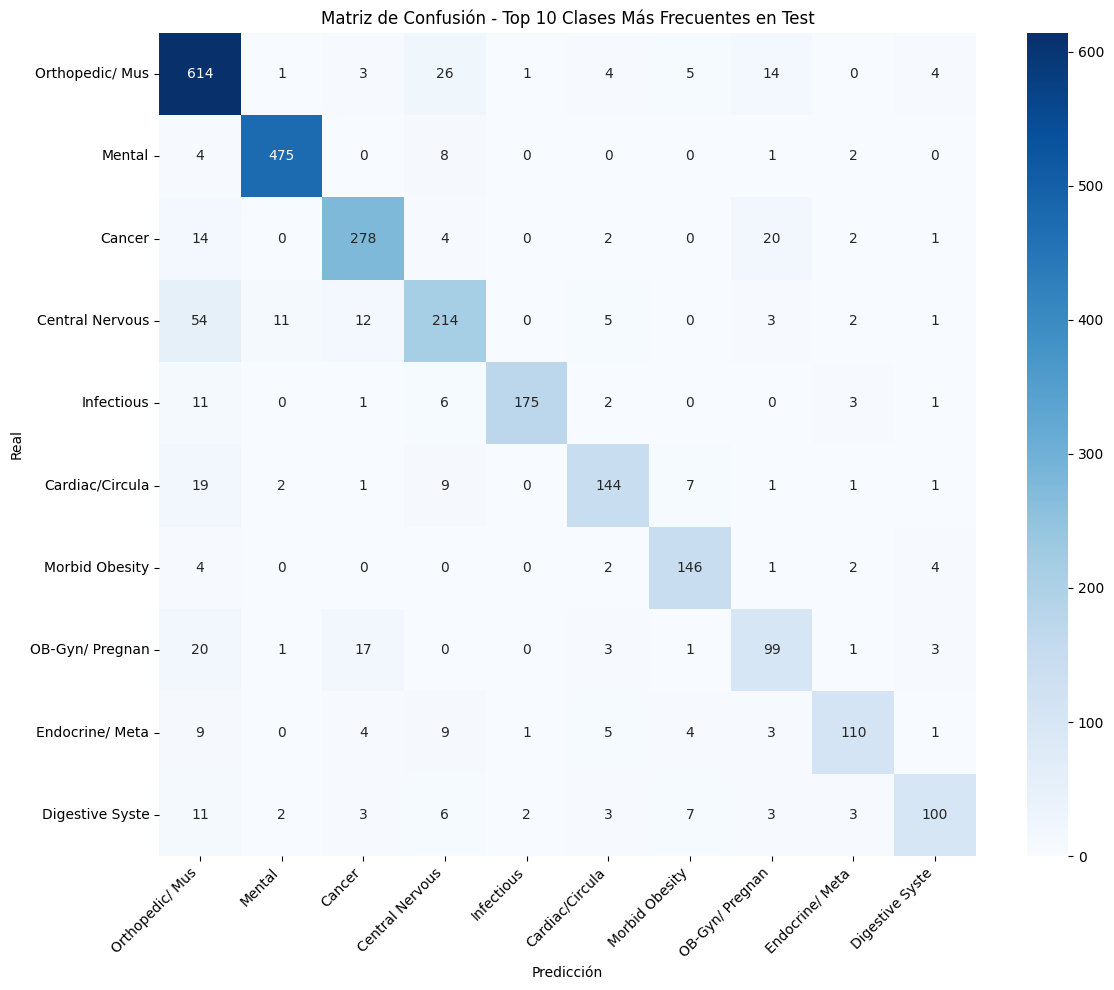


❌ ANÁLISIS DE ERRORES:
   Total errores: 1061/3923 (27.05%)

🔍 EJEMPLOS DE ERRORES:
   Error 1:
     Real: Central Nervous System/ Neuromuscular
     Predicho: Orthopedic/ Musculoskeletal (confianza: 0.182)

   Error 2:
     Real: OB-Gyn/ Pregnancy
     Predicho: Cancer (confianza: 0.796)

   Error 3:
     Real: Digestive System/ Gastrointestinal
     Predicho: Orthopedic/ Musculoskeletal (confianza: 0.540)

   Error 4:
     Real: Central Nervous System/ Neuromuscular
     Predicho: Orthopedic/ Musculoskeletal (confianza: 0.734)

   Error 5:
     Real: Foot
     Predicho: Orthopedic/ Musculoskeletal (confianza: 0.426)


📊 DISTRIBUCIÓN DE CONFIANZA:
   Confianza promedio: 0.7175
   Confianza mediana: 0.8101
   Predicciones con >90% confianza: 1479/3923 (37.7%)
   Predicciones con >80% confianza: 2000/3923 (51.0%)
   Predicciones con >70% confianza: 2351/3923 (59.9%)


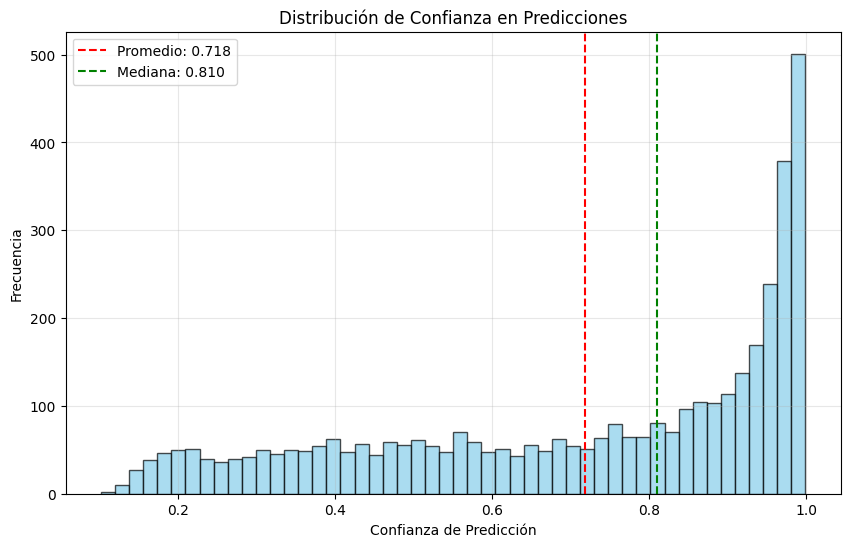


✅ Evaluación detallada completada


In [30]:
# CELDA CORREGIDA: Evaluación detallada modelo v11
print("\n📊 EVALUACIÓN DETALLADA MODELO V11")
print("=" * 60)

if 'modelo_v11' in locals() and 'y_test_v11' in locals():
    # Obtener clases únicas presentes en los datos de prueba
    clases_unicas_test = np.unique(y_test_v11)
    nombres_clases_test = [clases_v11[i] for i in clases_unicas_test]
    
    print(f"🔍 INFORMACIÓN DE CLASES:")
    print(f"   Total clases modelo: {len(clases_v11)}")
    print(f"   Clases en datos prueba: {len(clases_unicas_test)}")
    
    # Reporte de clasificación con labels específicos
    print("\n📋 REPORTE DE CLASIFICACIÓN:")
    reporte = classification_report(y_test_v11, y_test_pred_v11, 
                                   labels=clases_unicas_test,
                                   target_names=nombres_clases_test, 
                                   output_dict=True,
                                   zero_division=0)
    
    # Mostrar métricas por clase
    print(f"\n{'CLASE':<25} {'PRECISIÓN':<10} {'RECALL':<10} {'F1-SCORE':<10} {'SOPORTE':<10}")
    print("-" * 75)
    
    for i, clase_idx in enumerate(clases_unicas_test):
        if str(i) in reporte:
            precision = reporte[str(i)]['precision']
            recall = reporte[str(i)]['recall']
            f1 = reporte[str(i)]['f1-score']
            support = reporte[str(i)]['support']
            clase_nombre = clases_v11[clase_idx]
            print(f"{clase_nombre[:24]:<25} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {support:<10}")
    
    # Métricas generales
    print(f"\n📈 MÉTRICAS GENERALES:")
    print(f"   🎯 Precisión macro: {reporte['macro avg']['precision']:.4f}")
    print(f"   🎯 Recall macro: {reporte['macro avg']['recall']:.4f}")
    print(f"   🎯 F1-Score macro: {reporte['macro avg']['f1-score']:.4f}")
    print(f"   🎯 Precisión weighted: {reporte['weighted avg']['precision']:.4f}")
    print(f"   🎯 Recall weighted: {reporte['weighted avg']['recall']:.4f}")
    print(f"   🎯 F1-Score weighted: {reporte['weighted avg']['f1-score']:.4f}")
    
    # Matriz de confusión
    print(f"\n🔍 MATRIZ DE CONFUSIÓN:")
    cm = confusion_matrix(y_test_v11, y_test_pred_v11, labels=clases_unicas_test)
    
    # Crear visualización de matriz de confusión
    plt.figure(figsize=(12, 10))
    
    # Limitar a top 10 clases más frecuentes en test
    if len(clases_unicas_test) > 10:
        # Contar frecuencias en datos de prueba
        test_counts = [(idx, np.sum(y_test_v11 == idx)) for idx in clases_unicas_test]
        test_counts.sort(key=lambda x: x[1], reverse=True)
        top_10_indices = [idx for idx, count in test_counts[:10]]
        
        # Mapear a posiciones en clases_unicas_test
        top_positions = [list(clases_unicas_test).index(idx) for idx in top_10_indices]
        
        # Filtrar matriz y nombres
        cm_filtered = cm[np.ix_(top_positions, top_positions)]
        nombres_top = [clases_v11[idx][:15] for idx in top_10_indices]
        
        sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues',
                   xticklabels=nombres_top,
                   yticklabels=nombres_top)
        plt.title('Matriz de Confusión - Top 10 Clases Más Frecuentes en Test')
        print("   📊 Mostrando matriz de confusión para las 10 clases más frecuentes en test")
    else:
        nombres_todas = [clases_v11[idx][:15] for idx in clases_unicas_test]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=nombres_todas,
                   yticklabels=nombres_todas)
        plt.title('Matriz de Confusión - Todas las Clases en Test')
    
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Análisis de errores
    print(f"\n❌ ANÁLISIS DE ERRORES:")
    errores = y_test_v11 != y_test_pred_v11
    num_errores = np.sum(errores)
    
    print(f"   Total errores: {num_errores}/{len(y_test_v11)} ({num_errores/len(y_test_v11)*100:.2f}%)")
    
    if num_errores > 0:
        # Mostrar algunos casos de error
        indices_errores = np.where(errores)[0][:5]  # Primeros 5 errores
        
        print(f"\n🔍 EJEMPLOS DE ERRORES:")
        for i, idx in enumerate(indices_errores, 1):
            real = clases_v11[y_test_v11[idx]]
            predicho = clases_v11[y_test_pred_v11[idx]]
            confianza = np.max(y_test_proba_v11[idx])
            
            print(f"   Error {i}:")
            print(f"     Real: {real}")
            print(f"     Predicho: {predicho} (confianza: {confianza:.3f})")
            print()
    
    # Distribución de confianza
    print(f"\n📊 DISTRIBUCIÓN DE CONFIANZA:")
    confianzas = np.max(y_test_proba_v11, axis=1)
    
    print(f"   Confianza promedio: {np.mean(confianzas):.4f}")
    print(f"   Confianza mediana: {np.median(confianzas):.4f}")
    print(f"   Predicciones con >90% confianza: {np.sum(confianzas > 0.9)}/{len(confianzas)} ({np.sum(confianzas > 0.9)/len(confianzas)*100:.1f}%)")
    print(f"   Predicciones con >80% confianza: {np.sum(confianzas > 0.8)}/{len(confianzas)} ({np.sum(confianzas > 0.8)/len(confianzas)*100:.1f}%)")
    print(f"   Predicciones con >70% confianza: {np.sum(confianzas > 0.7)}/{len(confianzas)} ({np.sum(confianzas > 0.7)/len(confianzas)*100:.1f}%)")
    
    # Gráfico de distribución de confianza
    plt.figure(figsize=(10, 6))
    plt.hist(confianzas, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(confianzas), color='red', linestyle='--', label=f'Promedio: {np.mean(confianzas):.3f}')
    plt.axvline(np.median(confianzas), color='green', linestyle='--', label=f'Mediana: {np.median(confianzas):.3f}')
    plt.xlabel('Confianza de Predicción')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Confianza en Predicciones')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\n✅ Evaluación detallada completada")
    
else:
    print("❌ Modelo no está entrenado o faltan datos de prueba")

In [31]:
# CELDA MODIFICADA: Guardar modelo v11 en componentes separados
print("\n💾 GUARDANDO MODELO V11 EN COMPONENTES SEPARADOS")
print("=" * 55)

if 'modelo_v11' in locals():
    try:
        # Crear directorios
        os.makedirs("models", exist_ok=True)
        os.makedirs("models/v11_components", exist_ok=True)
        
        print("🔧 Guardando componentes por separado...")
        
        # 1. Modelo XGBoost principal
        with open('models/v11_components/modelo_xgb.pkl', 'wb') as f:
            pickle.dump(modelo_v11, f)
        print("✅ modelo_xgb.pkl guardado")
        
        # 2. Vectorizador TF-IDF
        with open('models/v11_components/tfidf_vectorizer.pkl', 'wb') as f:
            pickle.dump(tfidf_vectorizer_v11, f)
        print("✅ tfidf_vectorizer.pkl guardado")
        
        # 3. Encoders individuales
        with open('models/v11_components/age_encoder.pkl', 'wb') as f:
            pickle.dump(age_encoder_v11, f)
        print("✅ age_encoder.pkl guardado")
        
        with open('models/v11_components/gender_encoder.pkl', 'wb') as f:
            pickle.dump(gender_encoder_v11, f)
        print("✅ gender_encoder.pkl guardado")
        
        with open('models/v11_components/diagnosis_encoder.pkl', 'wb') as f:
            pickle.dump(diagnosis_encoder_v11, f)
        print("✅ diagnosis_encoder.pkl guardado")
        
        # 4. Extraer datos del preprocesador (sin Sentence-BERT cargado)
        preprocesador_data = {
            'medical_translations': preprocesador_v11.medical_translations,
            'embedding_dim': preprocesador_v11.embedding_dim,
            'stop_words_en': list(preprocesador_v11.stop_words_en),
            'stop_words_es': list(preprocesador_v11.stop_words_es),
            'lemmatizer_available': preprocesador_v11.lemmatizer is not None
        }
        
        with open('models/v11_components/preprocesador_data.pkl', 'wb') as f:
            pickle.dump(preprocesador_data, f)
        print("✅ preprocesador_data.pkl guardado")
        
        # 5. Metadatos del modelo
        metadata = {
            'clases': clases_v11,
            'precision': test_accuracy_v11,
            'fecha': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'num_clases': len(clases_v11),
            'embedding_dim': 384,
            'version': 'v11'
        }
        
        with open('models/v11_components/metadata.pkl', 'wb') as f:
            pickle.dump(metadata, f)
        print("✅ metadata.pkl guardado")
        
        # 6. Verificar tamaños de archivos
        print(f"\n📊 VERIFICACIÓN DE TAMAÑOS:")
        componentes = [
            'modelo_xgb.pkl',
            'tfidf_vectorizer.pkl', 
            'age_encoder.pkl',
            'gender_encoder.pkl',
            'diagnosis_encoder.pkl',
            'preprocesador_data.pkl',
            'metadata.pkl'
        ]
        
        total_size = 0
        for comp in componentes:
            path = f'models/v11_components/{comp}'
            if os.path.exists(path):
                size = os.path.getsize(path)
                size_mb = size / (1024 * 1024)
                total_size += size
                
                status = "✅" if size_mb < 100 else "⚠️"
                print(f"   {status} {comp}: {size_mb:.2f} MB")
        
        total_mb = total_size / (1024 * 1024)
        print(f"\n📈 RESUMEN:")
        print(f"   📦 Total: {total_mb:.2f} MB")
        print(f"   📄 Archivos: {len(componentes)}")
        print(f"   🎯 Precisión: {test_accuracy_v11:.4f} ({test_accuracy_v11*100:.2f}%)")
        print(f"   📅 Fecha: {metadata['fecha']}")
        
        if total_mb < 500:
            print("✅ Tamaño total apropiado para GitHub")
        else:
            print("⚠️ Tamaño total grande - considera usar Git LFS")
        
        print("\n🎯 Modelo v11 guardado exitosamente en componentes separados")
        print("💡 Listo para GitHub sin problemas de tamaño")
            
    except Exception as e:
        print(f"❌ Error: {e}")
else:
    print("❌ No hay modelo entrenado")


💾 GUARDANDO MODELO V11 EN COMPONENTES SEPARADOS
🔧 Guardando componentes por separado...
✅ modelo_xgb.pkl guardado
✅ tfidf_vectorizer.pkl guardado
✅ age_encoder.pkl guardado
✅ gender_encoder.pkl guardado
✅ diagnosis_encoder.pkl guardado
✅ preprocesador_data.pkl guardado
✅ metadata.pkl guardado

📊 VERIFICACIÓN DE TAMAÑOS:
   ✅ modelo_xgb.pkl: 25.08 MB
   ✅ tfidf_vectorizer.pkl: 0.06 MB
   ✅ age_encoder.pkl: 0.00 MB
   ✅ gender_encoder.pkl: 0.00 MB
   ✅ diagnosis_encoder.pkl: 0.01 MB
   ✅ preprocesador_data.pkl: 0.00 MB
   ✅ metadata.pkl: 0.01 MB

📈 RESUMEN:
   📦 Total: 25.16 MB
   📄 Archivos: 7
   🎯 Precisión: 0.7295 (72.95%)
   📅 Fecha: 2025-06-29 21:54:47
✅ Tamaño total apropiado para GitHub

🎯 Modelo v11 guardado exitosamente en componentes separados
💡 Listo para GitHub sin problemas de tamaño


In [32]:
# CELDA 1: Cargar modelo v11 y sus componentes
import pickle
import os

print("🔄 Cargando modelo v11 y componentes...")

componentes_path = "models/v11_components"

with open(os.path.join(componentes_path, "modelo_xgb.pkl"), "rb") as f:
    modelo_v11 = pickle.load(f)
with open(os.path.join(componentes_path, "tfidf_vectorizer.pkl"), "rb") as f:
    tfidf_vectorizer_v11 = pickle.load(f)
with open(os.path.join(componentes_path, "age_encoder.pkl"), "rb") as f:
    age_encoder_v11 = pickle.load(f)
with open(os.path.join(componentes_path, "gender_encoder.pkl"), "rb") as f:
    gender_encoder_v11 = pickle.load(f)
with open(os.path.join(componentes_path, "diagnosis_encoder.pkl"), "rb") as f:
    diagnosis_encoder_v11 = pickle.load(f)
with open(os.path.join(componentes_path, "preprocesador_data.pkl"), "rb") as f:
    preprocesador_data = pickle.load(f)
with open(os.path.join(componentes_path, "metadata.pkl"), "rb") as f:
    metadata = pickle.load(f)

print("✅ Modelo y componentes cargados correctamente")
print(f"   Diagnósticos: {metadata['num_clases']}")
print(f"   Precisión test: {metadata['precision']:.4f}")

🔄 Cargando modelo v11 y componentes...
✅ Modelo y componentes cargados correctamente
   Diagnósticos: 44
   Precisión test: 0.7295


In [33]:
# CELDA 2: Pruebas rápidas de predicción con modelo v11
print("\n🧪 Pruebas rápidas de predicción con modelo v11")

# Ejemplo de textos para probar
ejemplos = [
    "tengo dolor de cabeza intenso y fiebre alta",
    "I feel chest pain and shortness of breath",
    "me duele el estómago y tengo vómitos",
    "dolor lumbar crónico sin irradiación"
]

# Preprocesamiento rápido (usa solo TF-IDF y categóricas, embeddings opcional)
def preprocesar_entrada(texto, preprocesador_data, tfidf_vectorizer, age_encoder, gender_encoder):
    # Simula preprocesamiento mínimo (ajusta según tu pipeline real)
    texto_limpio = texto.lower()
    X_tfidf = tfidf_vectorizer.transform([texto_limpio])
    # Por defecto, usa 'Unknown' para edad y género
    X_age = age_encoder.transform(['Unknown'])
    X_gender = gender_encoder.transform(['Unknown'])
    from scipy.sparse import hstack, csr_matrix
    X_categorical = csr_matrix([[X_age[0], X_gender[0]]])
    # Si tu modelo requiere embeddings, agrega un vector de ceros del tamaño correcto
    embedding_dim = preprocesador_data.get('embedding_dim', 0)
    if embedding_dim > 0:
        X_embeddings = csr_matrix([ [0]*embedding_dim ])
        X_final = hstack([X_tfidf, X_embeddings, X_categorical])
    else:
        X_final = hstack([X_tfidf, X_categorical])
    return X_final

for texto in ejemplos:
    X_input = preprocesar_entrada(
        texto, preprocesador_data, tfidf_vectorizer_v11, age_encoder_v11, gender_encoder_v11
    )
    y_pred = modelo_v11.predict(X_input)
    y_pred_label = diagnosis_encoder_v11.inverse_transform(y_pred)[0]
    y_proba = modelo_v11.predict_proba(X_input).max()
    print(f"📝 \"{texto}\" → Predicción: {y_pred_label} (confianza: {y_proba:.2f})")


🧪 Pruebas rápidas de predicción con modelo v11
📝 "tengo dolor de cabeza intenso y fiebre alta" → Predicción: Cardiovascular (confianza: 0.22)
📝 "I feel chest pain and shortness of breath" → Predicción: Cardiovascular (confianza: 0.34)
📝 "me duele el estómago y tengo vómitos" → Predicción: Cardiovascular (confianza: 0.22)
📝 "dolor lumbar crónico sin irradiación" → Predicción: Cardiovascular (confianza: 0.21)
